In [1]:
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


import numpy as np
from numpy import random
import matplotlib.pyplot as plt
# import autokeras as ak
import os 
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
        
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

logging.info("numpy Version is {}".format(np.__version__))
# logging.info("autokeras Version is {}".format(ak.__version__))
logging.info("tensorflow Version is {}".format(tf.keras.__version__))
logging.info("\n")

!nvidia-smi
%config InlineBackend. figure_format = 'retina'

INFO:root:numpy Version is 1.19.5
INFO:root:tensorflow Version is 2.4.0
INFO:root:



1 Physical GPUs, 1 Logical GPU
Wed Oct 13 01:10:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM-80GB       On   | 00000000:4C:00.0 Off |                    0 |
| N/A   30C    P0    67W / 400W |    568MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                         

In [40]:
%%time
#Load Model
experiment = "dune"

model_theta23 = { }
model_delta = { }
scale_range = range(0, 40, 1)[34:]

for i in scale_range:
    model_theta23.update({"std_scale_"+str(i): 0}) 
    model_delta.update({"std_scale_"+str(i): 0}) 
                      
        

for i, (std_scale, nth_scale) in enumerate(zip(model_theta23, scale_range)):
    
    file_path = "/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/" + str(experiment) + "_" + "theta23_std" + "_" + str(nth_scale) + "_poisson_10_.h5"
    
    if os.path.isfile(file_path):
        
        logging.info(str(file_path) +" exists.")

        model_theta23[std_scale] = load_model(file_path)

    else:
        logging.info("Please Check Input Files!!!")
        raise ValueError("Please Check Input Files!!!")

logging.info("\n")
        
for i, (std_scale, nth_scale) in enumerate(zip(model_delta, scale_range)):
    
    file_path = "/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/" + str(experiment) + "_" + "delta_std" + "_" + str(nth_scale) + "_poisson_10_2.h5"
    
    if os.path.isfile(file_path):
        
        logging.info(str(file_path) +" exists.")

        model_delta[std_scale] = load_model(file_path)

    else:
        logging.info("Please Check Input Files!!!")
        raise ValueError("Please Check Input Files!!!")
        
# if model_theta23["std_scale_0"] != 0 and model_delta["std_scale_0"] != 0:
#     logging.info("\n")
#     model_theta23["std_scale_0"].summary()
#     logging.info("\n")
#     model_delta["std_scale_0"].summary()
# else:
#     pass
    
logging.info("\n")
logging.info("All Models are loaded!")

INFO:root:/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/dune_theta23_std_34_poisson_10_.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/dune_theta23_std_35_poisson_10_.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/dune_theta23_std_36_poisson_10_.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/dune_theta23_std_37_poisson_10_.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/dune_theta23_std_38_poisson_10_.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/dune_theta23_std_39_poisson_10_.h5 exists.
INFO:root:

INFO:root:/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/dune_delta_std_34_poisson_10_2.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4NO/Regression_std_Study/Model_to_5Gev/dune_delta_std_35_poisson_10_2.h5 exists.
INFO:root:/dicos_ui_home/alanchung/ML4

CPU times: user 1.43 s, sys: 84.3 ms, total: 1.51 s
Wall time: 1.5 s


In [104]:
%%time
test_data = np.load('../Data/sample_NuFit0911.npz')
data_mid = np.column_stack([test_data["ve_"+str(experiment)][:,:36], test_data["vu_"+str(experiment)][:,:36], test_data["vebar_"+str(experiment)][:,:36], test_data["vubar_"+str(experiment)][:,:36]])
# data_mid = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
# data_mid = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune'],data['ve_t2hk'], data['vu_t2hk'], data['vebar_t2hk'], data['vubar_t2hk']])
data_IO_mid = data_mid[0]
data_NO_mid = data_mid[1]

logging.info("Test IO Data Shape:{}".format(data_IO_mid.shape))
logging.info("Test NO Data Shape:{}".format(data_NO_mid.shape))

INFO:root:Test IO Data Shape:(144,)
INFO:root:Test NO Data Shape:(144,)


CPU times: user 3.79 ms, sys: 1.08 ms, total: 4.87 ms
Wall time: 3.95 ms


In [144]:
%%time
N = 100000#0


IO_or_NO = 0 # 0 for IO and 1 for NO


if IO_or_NO == 0:
    logging.info("IO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][0], test_data['delta'][0]))
    
    data_asimov = data_IO_mid.reshape(1,data_IO_mid.shape[0])
    data_poisson = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
    ordering = "Inverse Ordering"
    
else:
    logging.info("NO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][1], test_data['delta'][1]))
    
    data_asimov = data_NO_mid.reshape(1,data_NO_mid.shape[0])
    data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
    ordering = "Normal Ordering"
    

INFO:root:IO
INFO:root:True point: theta_23 = 49.00 \delta_cp = 195.00


CPU times: user 1.96 s, sys: 59.5 ms, total: 2.02 s
Wall time: 2.02 s


In [145]:
%%time

def Contour(resolution_dictinary, model_dictinary, bin_size):

    for i, std_scale in enumerate(tqdm(resolution_dictinary)):

        prediction_asimov = model_dictinary[std_scale].predict(data_asimov)[0][0]
        tmp = model_dictinary[std_scale].predict(data_poisson)[:,0]
        hist, bin_edges = np.histogram(tmp, bins = bin_size)
        max_poi = np.where(hist == hist.max())

        """
        left boundary
        """
        tot_event_num = hist.sum()
        left_area = 0
        for left_boundary in range(len(hist)):
            left_area += hist[left_boundary]
            if left_area/tot_event_num >= 0.34:
                break

        left_boundary = bin_edges[left_boundary]

        """
        right boundary
        """
        tot_event_num = hist.sum()
        right_area = 0
        for right_boundary in np.linspace(len(hist)-1,0,len(hist)):
            right_area += hist[int(right_boundary)]
            if right_area/tot_event_num >= 0.34:
                break

        right_boundary = bin_edges[int(right_boundary)]
        
        logging.info("\n")
        logging.info(i)
        logging.info("prediction asimov: {:.1f}".format(prediction_asimov))
        logging.info("right_boundary: {:.1f}".format(right_boundary))
        logging.info("best fit: {:.1f}".format(bin_edges[max_poi][0]))
        logging.info("left_boundary: {:.1f}".format(left_boundary))
        logging.info("################")
        logging.info("\n")

        resolution_dictinary[std_scale]["poission_prediction"] = tmp
        resolution_dictinary[std_scale]["asimov"] = prediction_asimov
        resolution_dictinary[std_scale]["hist"] = hist
        resolution_dictinary[std_scale]["best_fit"] = bin_edges[max_poi][0]
        resolution_dictinary[std_scale]["p_yerr"] = right_boundary
        resolution_dictinary[std_scale]["n_yerr"] = left_boundary
    
    return resolution_dictinary
    
    
    

theta23_resolution = {}
delta_resolution = {}

for i in scale_range:
    theta23_resolution.update({"std_scale_"+str(i): {"poission_prediction":0, "asimov": 0, "hist": 0, "best_fit": 0, "p_yerr": 0 , "n_yerr": 0 , },}) 
    delta_resolution.update({"std_scale_"+str(i): {"poission_prediction":0, "asimov": 0, "hist": 0, "best_fit": 0, "p_yerr": 0 , "n_yerr": 0 , },}) 


    
# bins_theta23 = np.linspace(38.9, 51.1, 1000)
bins_theta23 = np.linspace(0, 360, 30000)
theta23_resolution = Contour(theta23_resolution, model_theta23, bins_theta23)
        
bins_delta = np.linspace(0, 360, 1000)
delta_resolution = Contour(delta_resolution, model_delta, bins_delta)
    
    

  0%|          | 0/6 [00:00<?, ?it/s]INFO:root:

INFO:root:0
INFO:root:prediction asimov: 49.1
INFO:root:right_boundary: 49.2
INFO:root:best fit: 48.9
INFO:root:left_boundary: 48.9
INFO:root:################
INFO:root:

 17%|█▋        | 1/6 [00:02<00:12,  2.41s/it]INFO:root:

INFO:root:1
INFO:root:prediction asimov: 49.0
INFO:root:right_boundary: 49.1
INFO:root:best fit: 49.0
INFO:root:left_boundary: 48.9
INFO:root:################
INFO:root:

 33%|███▎      | 2/6 [00:04<00:09,  2.42s/it]INFO:root:

INFO:root:2
INFO:root:prediction asimov: 49.0
INFO:root:right_boundary: 49.1
INFO:root:best fit: 49.0
INFO:root:left_boundary: 48.8
INFO:root:################
INFO:root:

 50%|█████     | 3/6 [00:07<00:07,  2.37s/it]INFO:root:

INFO:root:3
INFO:root:prediction asimov: 49.0
INFO:root:right_boundary: 49.1
INFO:root:best fit: 49.0
INFO:root:left_boundary: 48.8
INFO:root:################
INFO:root:

 67%|██████▋   | 4/6 [00:09<00:04,  2.37s/it]INFO:root:

INFO:root:4
INFO:root:prediction asimov

CPU times: user 35.6 s, sys: 3.69 s, total: 39.3 s
Wall time: 27.7 s


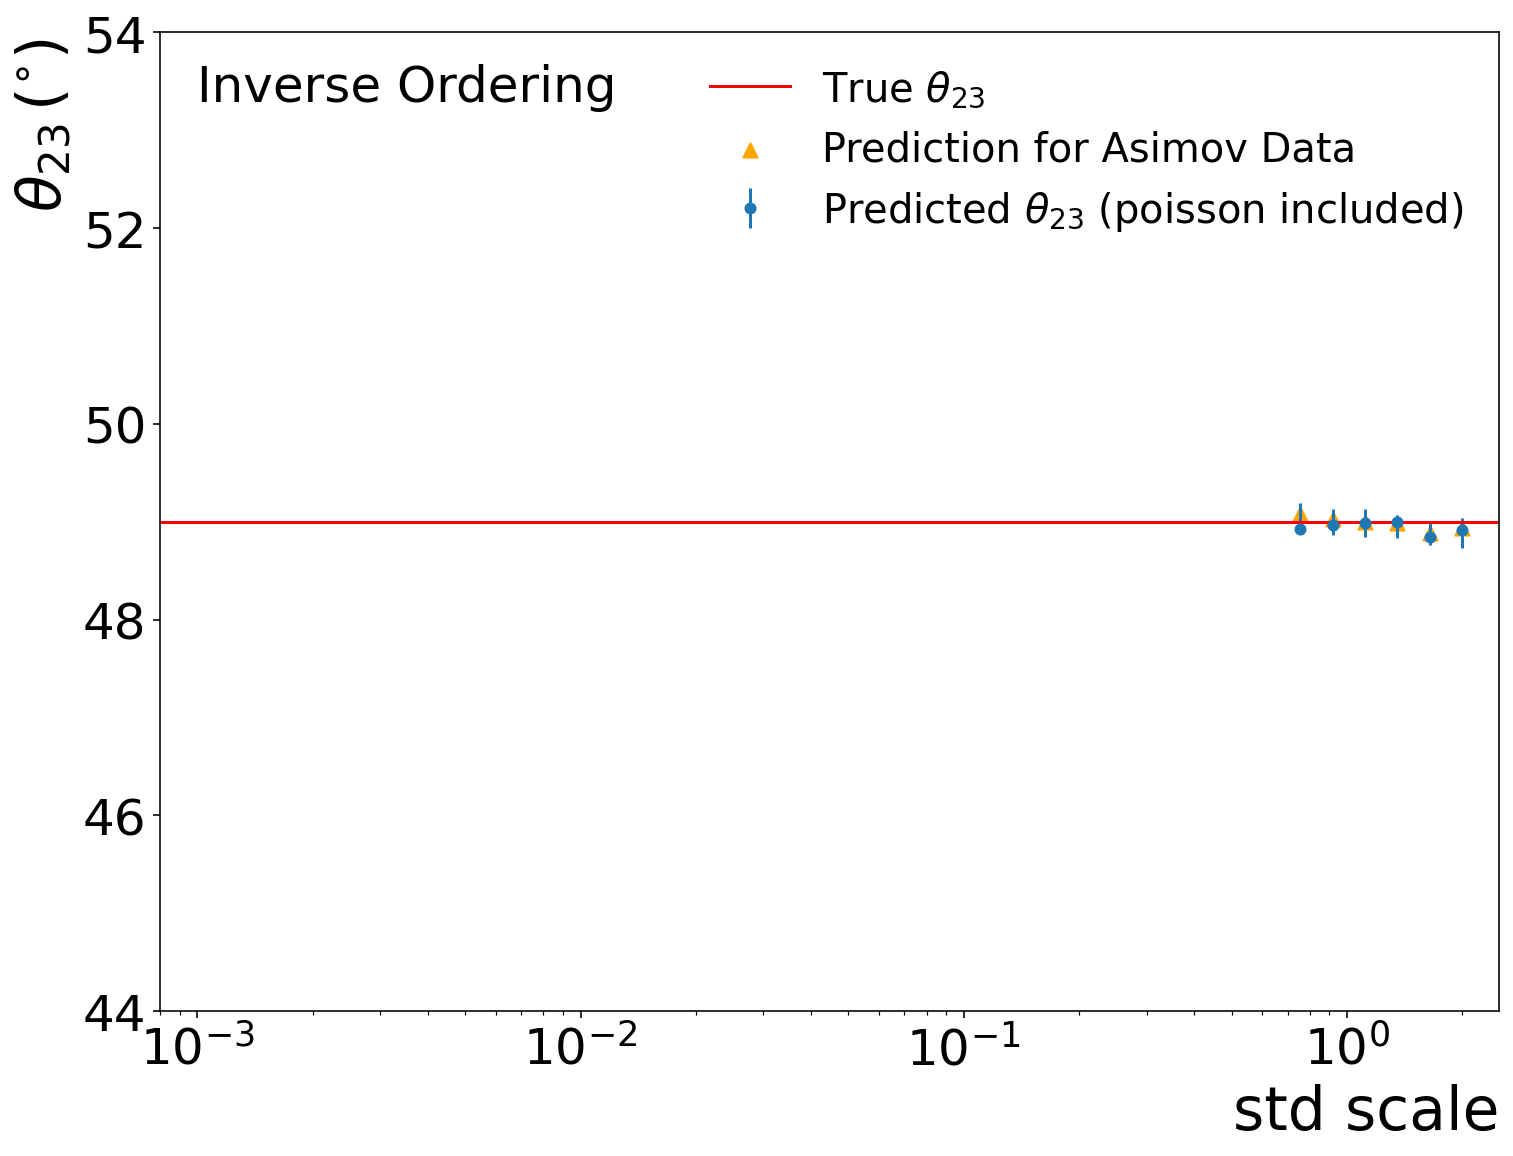

CPU times: user 516 ms, sys: 195 ms, total: 712 ms
Wall time: 530 ms


In [146]:
%%time

fig, ax = plt.subplots(1,1, figsize=(12,9))


std_scale = np.logspace(-3, np.log10(2), 40)[scale_range]
prediction_asimov = [theta23_resolution[std_scale]["asimov"] for std_scale in theta23_resolution]
best_fit = [theta23_resolution[std_scale]["best_fit"] for std_scale in theta23_resolution]
p_yerr = np.array([theta23_resolution[std_scale]["p_yerr"] for std_scale in theta23_resolution]) - np.array(best_fit)
n_yerr = np.array(best_fit) - np.array([theta23_resolution[std_scale]["n_yerr"] for std_scale in theta23_resolution])
uncertainty = [n_yerr, p_yerr]

plt.scatter(std_scale, prediction_asimov, color='orange', marker = "^", s=50, label="Prediction for Asimov Data")
plt.errorbar(std_scale, best_fit, yerr=uncertainty, fmt='o',ms=5, label="Predicted $\\theta_{23}$ (poisson included)")
plt.axhline(y=test_data['theta23'][IO_or_NO] , color='r', linestyle='-', label="True $\\theta_{23}$")

if IO_or_NO == 0:
    plt.text(x=0.001,y=53.3, s="Inverse Ordering", fontsize=25 )
elif IO_or_NO == 1:
    plt.text(x=0.001,y=53.3, s="Normal Ordering", fontsize=25 )


ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0.0008, 2.5))
plt.xscale("log")
plt.ylim((44, 54))
plt.xlabel("std scale", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("$\\theta_{23}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)
# plt.grid()

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
 


plt.show()

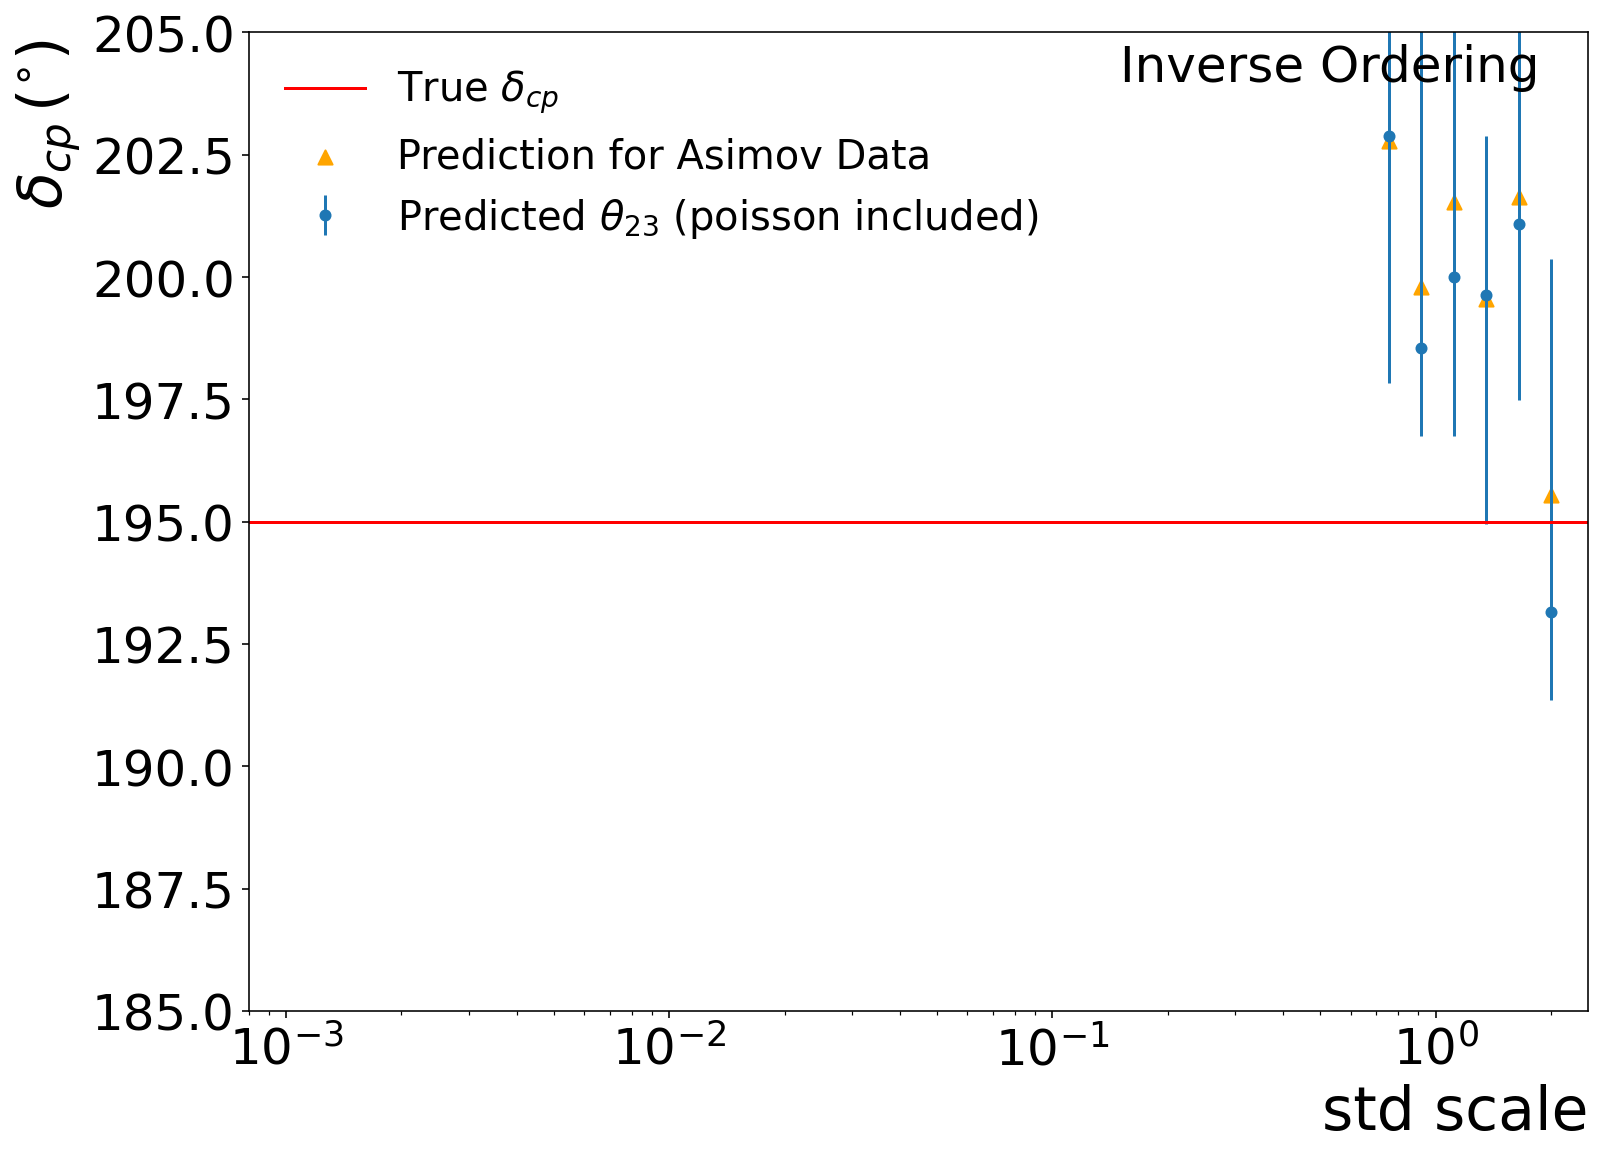

CPU times: user 553 ms, sys: 191 ms, total: 745 ms
Wall time: 562 ms


In [151]:
%%time

fig, ax = plt.subplots(1,1, figsize=(12,9))


std_scale = np.logspace(-3, np.log10(2), 40)[scale_range]
prediction_asimov = [delta_resolution[std_scale]["asimov"] for std_scale in delta_resolution]
best_fit = [delta_resolution[std_scale]["best_fit"] for std_scale in delta_resolution]
p_yerr = np.array([delta_resolution[std_scale]["p_yerr"] for std_scale in delta_resolution]) - np.array(best_fit)
n_yerr = np.array(best_fit) - np.array([delta_resolution[std_scale]["n_yerr"] for std_scale in delta_resolution])
uncertainty = [n_yerr, p_yerr]

plt.scatter(std_scale, prediction_asimov, color='orange', marker = "^", s=50, label="Prediction for Asimov Data")
plt.errorbar(std_scale, best_fit, yerr=uncertainty, fmt='o',ms=5, label="Predicted $\\theta_{23}$ (poisson included)")
plt.axhline(y=test_data['delta'][IO_or_NO] , color='r', linestyle='-', label="True $\delta_{cp}$")

if IO_or_NO == 0:
    plt.text(x=0.15,y=204, s="Inverse Ordering", fontsize=25 )
    plt.ylim((185, 205))
elif IO_or_NO == 1:
    plt.text(x=0.15,y=296, s="Normal Ordering", fontsize=25 )
    plt.ylim((200, 300))

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((0.0008, 2.5))
plt.xscale("log")
plt.xlabel("std scale", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("$\delta_{cp}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
 

    

plt.show()

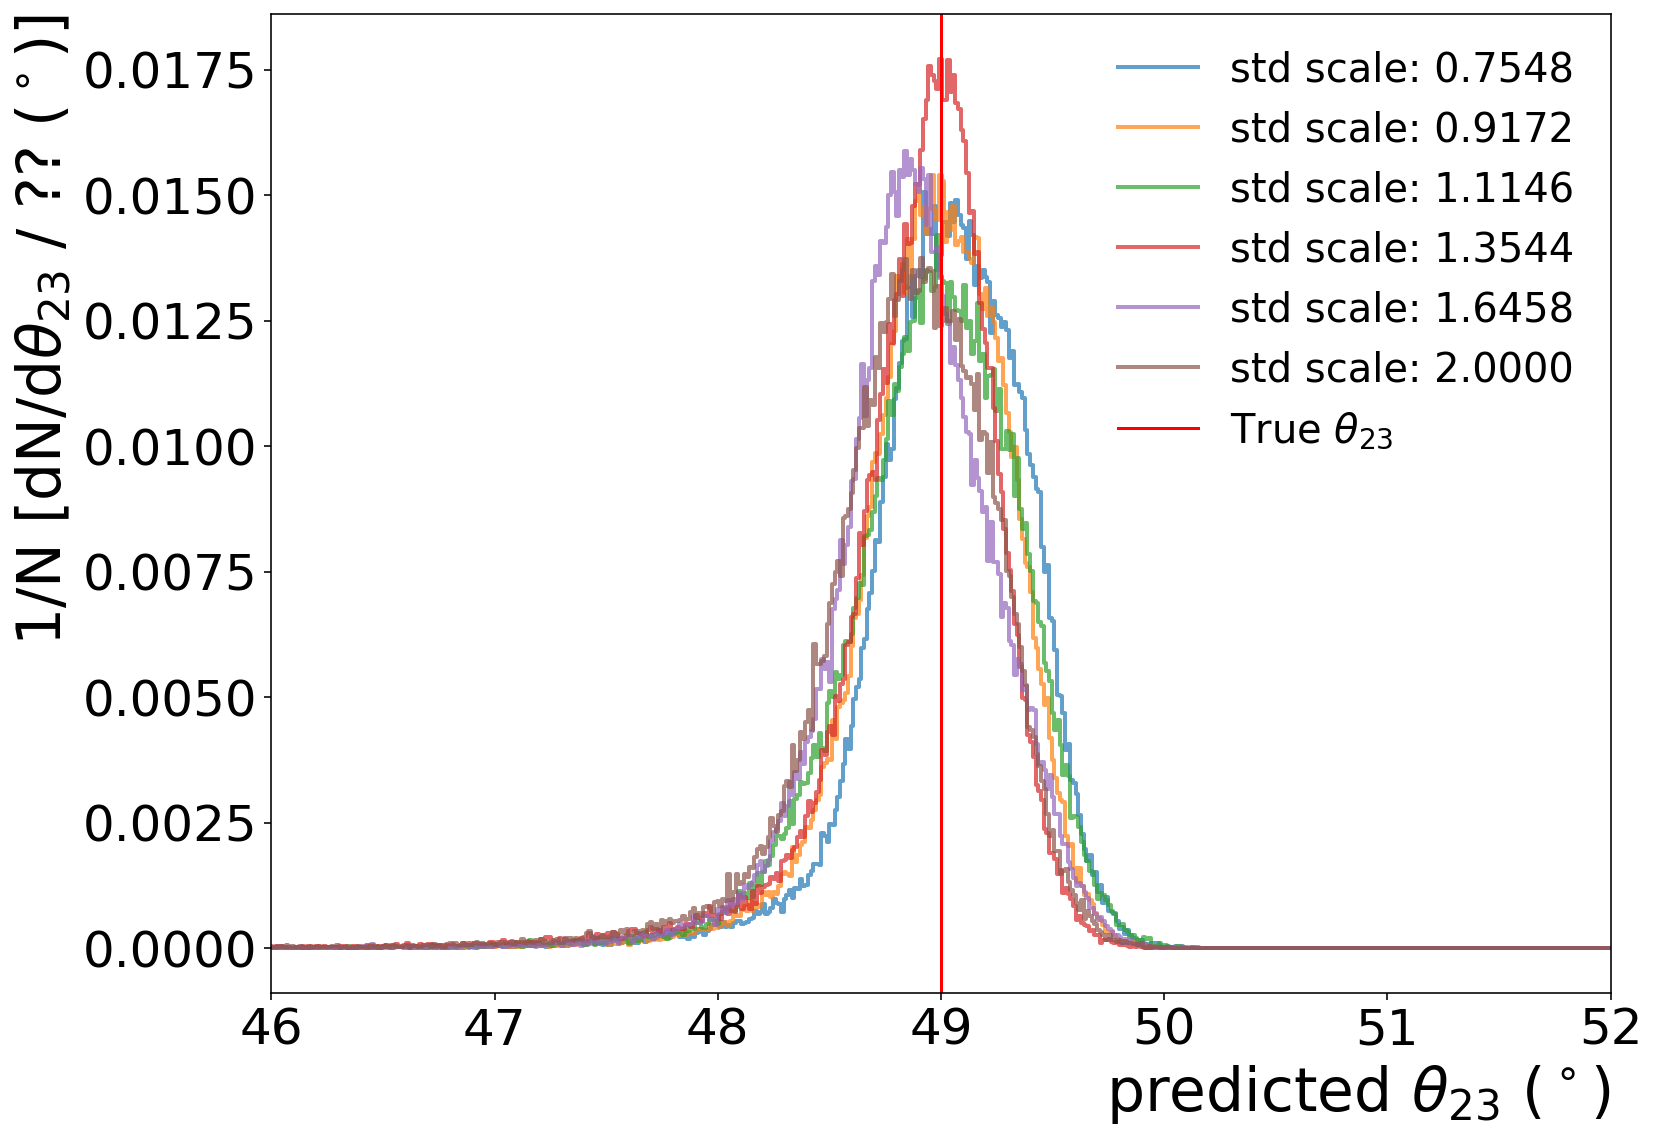

CPU times: user 484 ms, sys: 205 ms, total: 689 ms
Wall time: 507 ms


In [148]:
%%time
fig, ax = plt.subplots(1,1, figsize=(12,9))

# for i in scale_range[0,5,10,15,20,25,39]:
# for i in [0,5,10,15,20,25,39]:
for i in [34,35,36,37,38,39]:
    hist, bins = theta23_resolution["std_scale_"+str(i)]["hist"], bins_theta23
    
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
    #          hist.astype(np.float32) ,
             where='mid',
             linewidth=2, 
             alpha=0.7,
             label="std scale: {:.4f}".format(np.logspace(-3, np.log10(2), 40)[i])
            )
    
    
plt.axvline(x=test_data['theta23'][IO_or_NO] , color='r', linestyle='-', label="True $\\theta_{23}$")

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((46,52))
# plt.ylim((0., 0.18))
plt.xlabel("predicted $\\theta_{23}$ ($^\circ$)", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("1/N [dN/d$\\theta_{23}$ / ?? ($^\circ$)]", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
    


plt.show()

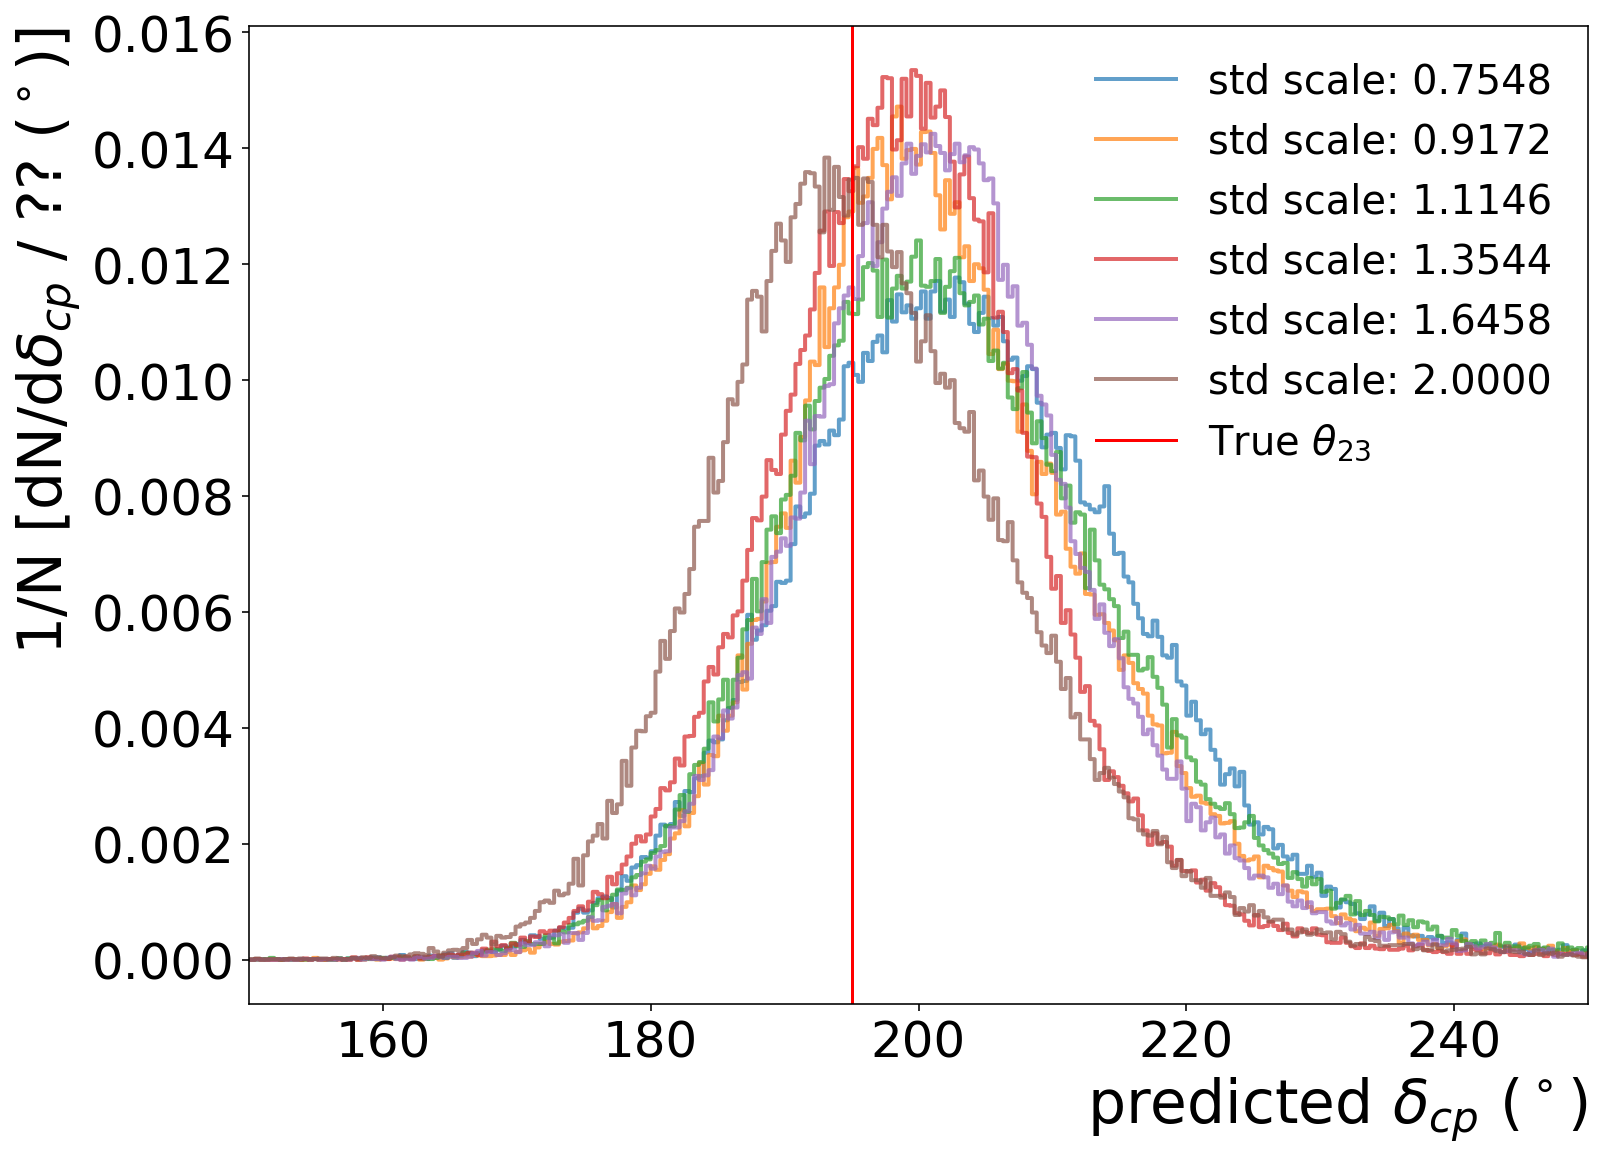

CPU times: user 427 ms, sys: 175 ms, total: 602 ms
Wall time: 421 ms


In [155]:
%%time
fig, ax = plt.subplots(1,1, figsize=(12,9))

# for i in scale_range[0,5,10,15,20,25,39]:
# for i in [0,5,10,15,20,25,39]:
for i in [34,35,36,37,38,39]:
    hist, bins = delta_resolution["std_scale_"+str(i)]["hist"], bins_delta
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
    #          hist.astype(np.float32) ,
             where='mid',
             linewidth=2, 
             alpha=0.7,
             label="std scale: {:.4f}".format(np.logspace(-3, np.log10(2), 40)[i])
            )

plt.axvline(x=test_data['delta'][IO_or_NO] , color='r', linestyle='-', label="True $\\theta_{23}$")
    
    
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

if IO_or_NO == 0:
    plt.xlim((150,250))
elif IO_or_NO == 1:
    plt.xlim((200,350))
             
# # plt.ylim((0., 0.18))
plt.xlabel("predicted $\delta_{cp}$ ($^\circ$)", fontsize=30,horizontalalignment='right',x=1)
plt.ylabel("1/N [dN/d$\delta_{cp}$ / ?? ($^\circ$)]", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
    


plt.show()

In [156]:
#總資料組數
N_DUNE = 92
N_T2HK = 36
N_DUT2 = 96

In [157]:
theta23_DUNE = []
delta_cp_DUNE = []
chi_DUNE = []
theta23_T2HK = []
delta_cp_T2HK = []
chi_T2HK = []
theta23_DUT2 = []
delta_cp_DUT2 = []
chi_DUT2 = []

In [158]:
%%time
#Import txt檔
f_DUNE = open("../Data/chi_square-4-2_figB_DUNE.txt")
for i in range(N_DUNE):
    s = f_DUNE.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUNE.append(array[0])
    delta_cp_DUNE.append(array[1]) 
    chi_DUNE.append(array[2])
f_DUNE.close()
f_T2HK = open("../Data/chi_square-4-2_figB_T2HK.txt")
for i in range(N_T2HK):
    s = f_T2HK.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_T2HK.append(array[0])
    delta_cp_T2HK.append(array[1]) 
    chi_T2HK.append(array[2])
f_T2HK.close()
f_DUT2 = open("../Data/chi_square-4-2_figB_DUT2.txt")
for i in range(N_DUT2):
    s = f_DUT2.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUT2.append(array[0])
    delta_cp_DUT2.append(array[1]) 
    chi_DUT2.append(array[2])
f_DUT2.close()

CPU times: user 2.23 ms, sys: 50 µs, total: 2.28 ms
Wall time: 5.34 ms


In [159]:
theta23_DUNE = np.array(theta23_DUNE)
delta_cp_DUNE = np.array(delta_cp_DUNE)
chi_DUNE = np.array(chi_DUNE)
theta23_T2HK = np.array(theta23_T2HK)
delta_cp_T2HK = np.array(delta_cp_T2HK)
chi_T2HK = np.array(chi_T2HK)
theta23_DUT2 = np.array(theta23_DUT2)
delta_cp_DUT2 = np.array(delta_cp_DUT2)
chi_DUT2 = np.array(chi_DUT2)

In [160]:
%%time
x0 = np.linspace(min(theta23_DUNE)-3, max(theta23_DUNE)+3, 68)
y0 = np.linspace(min(delta_cp_DUNE)-6, max(delta_cp_DUNE)+6, 20)
X0, Y0 = np.meshgrid(x0, y0)
Z0 = np.zeros((len(X0),len(X0[0])))

for i in range(len(theta23_DUNE)):
    a = np.where(X0 == theta23_DUNE[i])[1][0]
    b = np.where(Y0 == delta_cp_DUNE[i])[0][0]
    Z0[b][a] = 1

x1 = np.linspace(min(theta23_T2HK)-3, max(theta23_T2HK)+3, 65)
y1 = np.linspace(min(delta_cp_T2HK)-6, max(delta_cp_T2HK)+6, 14)
X1, Y1 = np.meshgrid(x1, y1)
Z1 = np.zeros((len(X1),len(X1[0])))

for i in range(len(theta23_T2HK)):
    a = np.where(X1 == theta23_T2HK[i])[1][0]
    b = np.where(Y1 == delta_cp_T2HK[i])[0][0]
    Z1[b][a] = 1

x2 = np.linspace(min(theta23_DUT2)-3, max(theta23_DUT2)+3, 129)
y2 = np.linspace(min(delta_cp_DUT2)-6, max(delta_cp_DUT2)+6, 25)
X2, Y2 = np.meshgrid(x2, y2)
Z2 = np.zeros((len(X2),len(X2[0])))

for i in range(len(theta23_DUT2)):
    a = np.where(X2 == theta23_DUT2[i])[1][0]
    b = np.where(Y2 == delta_cp_DUT2[i])[0][0]
    Z2[b][a] = 1

CPU times: user 6.06 ms, sys: 1.04 ms, total: 7.1 ms
Wall time: 6.38 ms


In [161]:
theta23_resolution.keys()

dict_keys(['std_scale_34', 'std_scale_35', 'std_scale_36', 'std_scale_37', 'std_scale_38', 'std_scale_39'])

In [165]:
%%time

index = 39
input_theta23 = theta23_resolution["std_scale_"+str(index)]["poission_prediction"]
input_delta = delta_resolution["std_scale_"+str(index)]["poission_prediction"]




bins_theta23_globes = np.linspace(0, 360, int(360/(x0[1]-x0[0])))
bins_delta_globes  = np.linspace(0, 360, int(360/(y0[1]-y0[0])))

likeliregion, xedges, yedges = np.histogram2d(input_theta23, input_delta, 
                                              bins = [bins_theta23_globes, bins_delta_globes]
                                             )
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
logging.info("Maximum: theta23: {:.2f}, delta: {:.2f} ".format(xedges[max_poi[1]][0],yedges[max_poi[0]][0]))
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]

tot_event_num = sorted_list.sum()

onesigma = 0
for i in range(len(sorted_list)):
    onesigma += sorted_list[i]
    if onesigma/tot_event_num >= 0.68:
        one_sigma_num = sorted_list[i]
        break
        
twosigma = 0
for i in range(len(sorted_list)):
    twosigma += sorted_list[i]        
    if twosigma/tot_event_num >= 0.95:
        two_sigma_num = sorted_list[i]
        break

one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion )
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region )
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion )
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region )
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

INFO:root:Maximum: theta23: 48.93, delta: 193.07 


CPU times: user 40.7 ms, sys: 0 ns, total: 40.7 ms
Wall time: 39.5 ms


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: No contour levels were found within the data range.


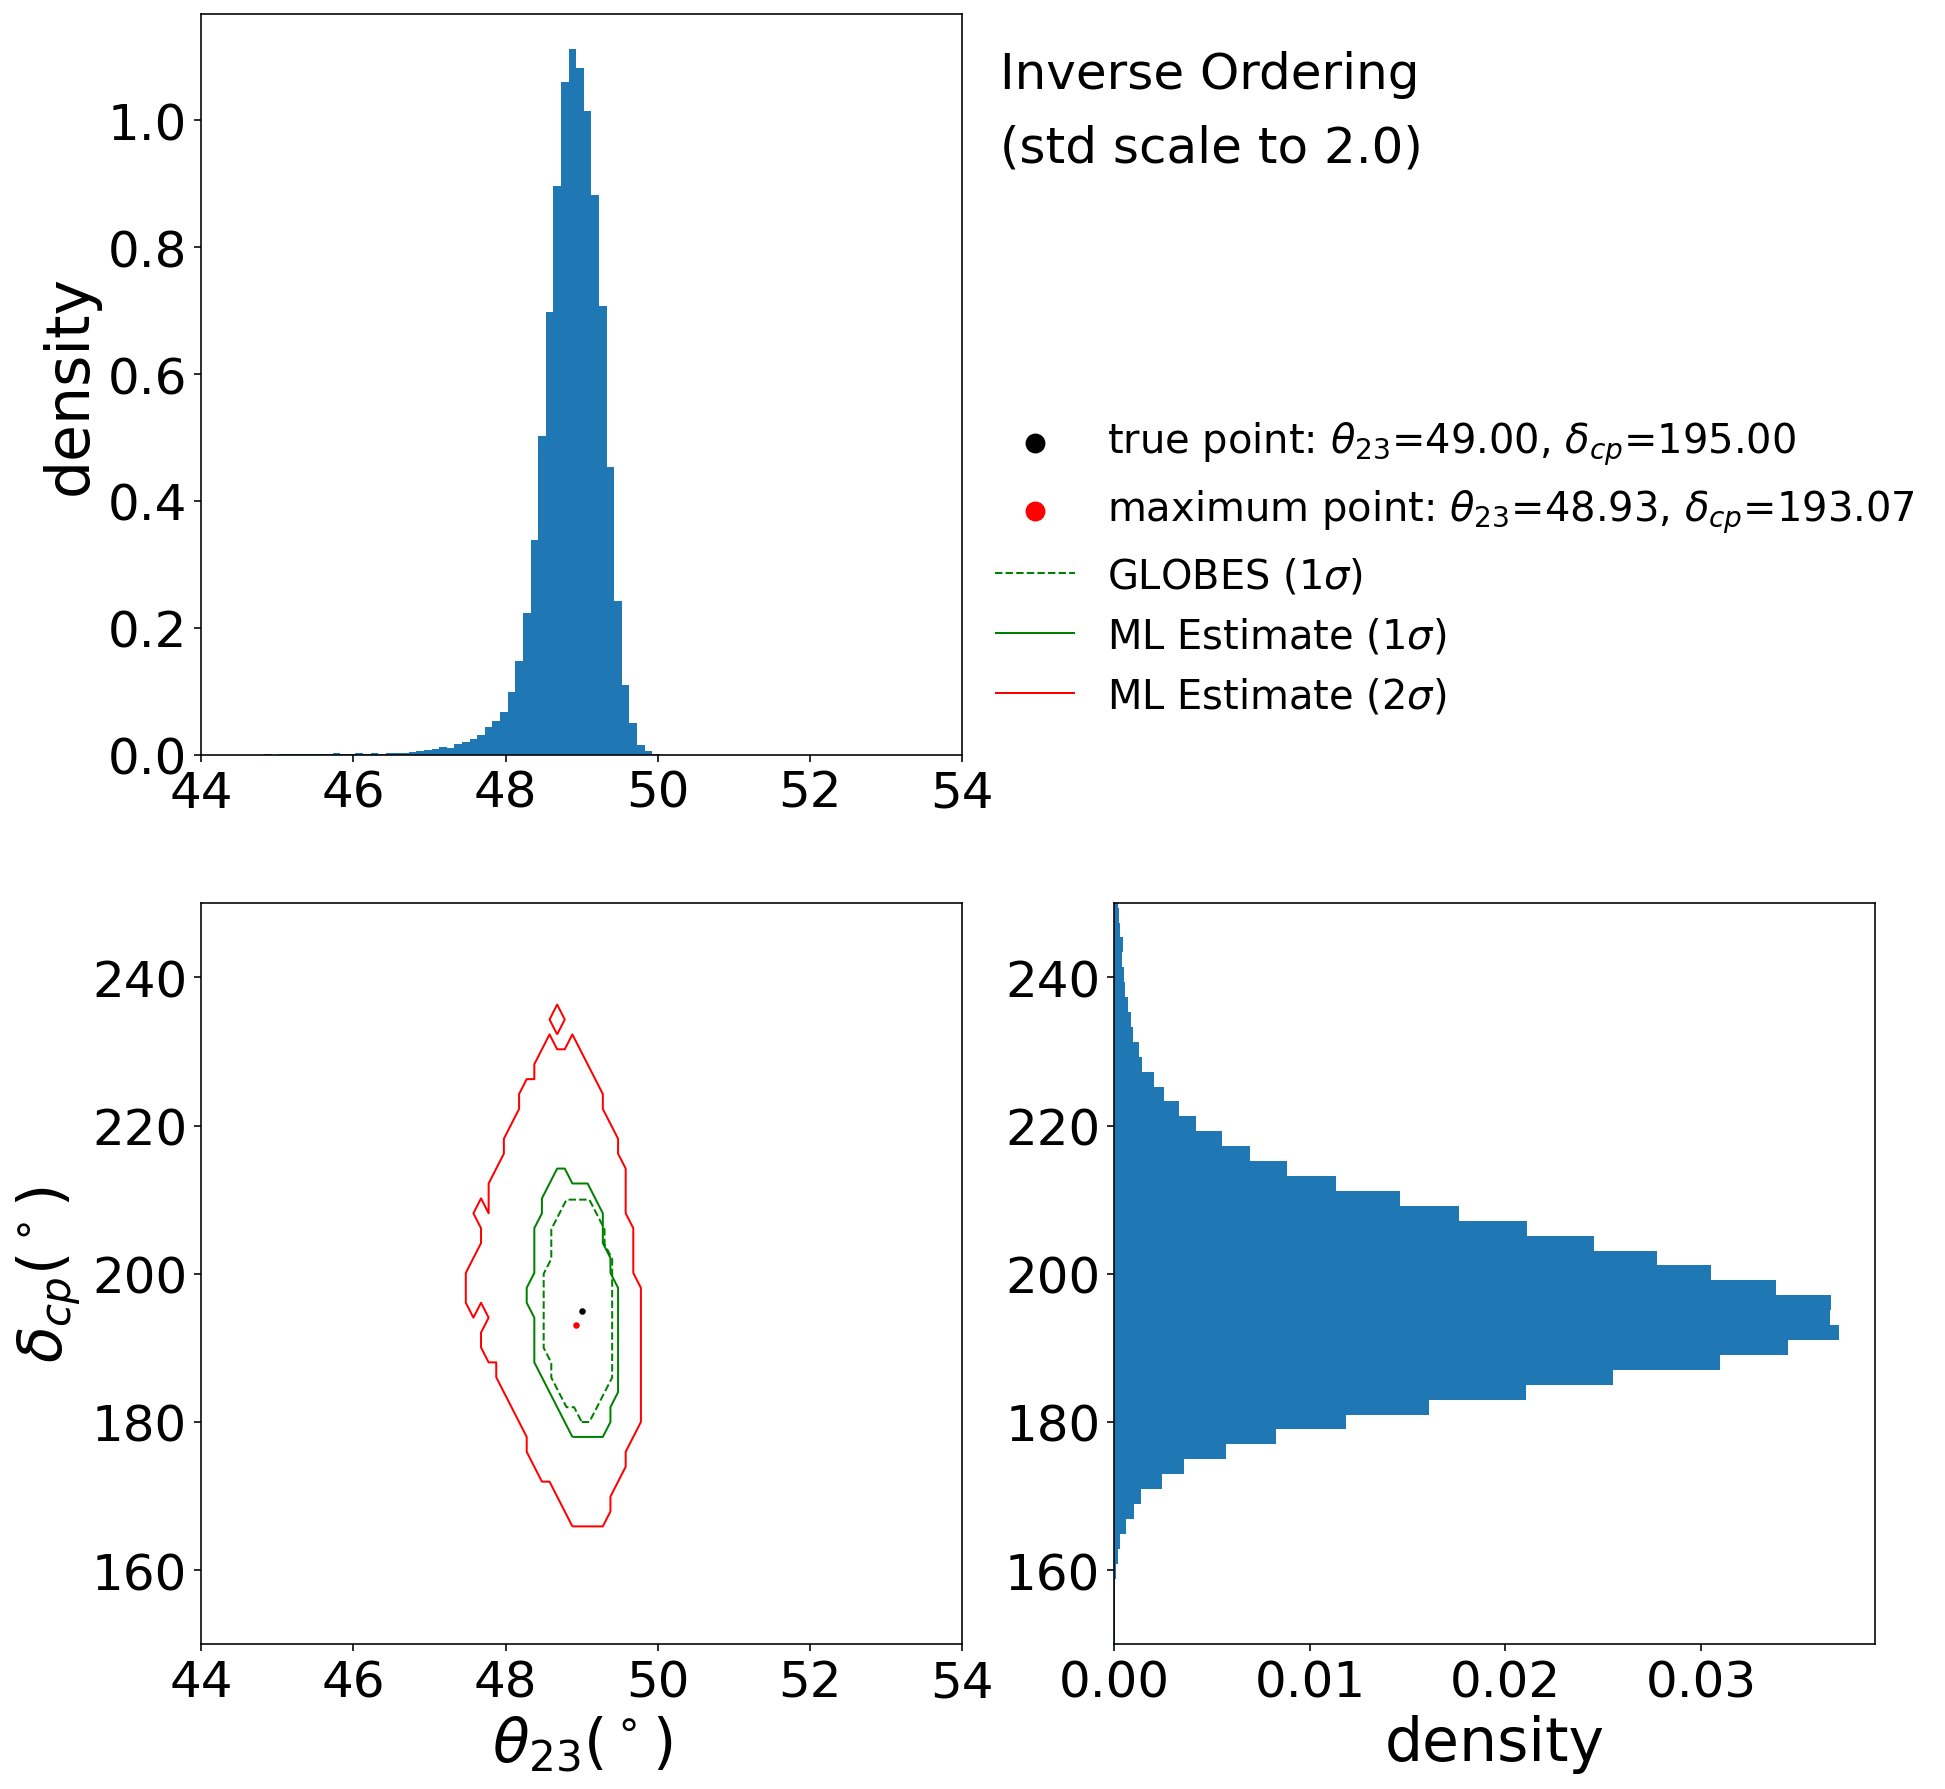

In [176]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

#=========================== Upper Left Corner
plot_axis = plt.subplot(2,2,1)
"""
ML
"""
plot_axis.hist(input_theta23,density=1,bins=bins_theta23_globes)
if IO_or_NO == 0:
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_xlim((44,54))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_ylabel(r'density', fontsize=30)
#===========================




#=========================== Down Right Corner
plot_axis = plt.subplot(2,2,4)
"""
ML
"""
plot_axis.hist(input_delta,orientation="horizontal",density=1, bins=bins_delta_globes)
if IO_or_NO == 0:
    plot_axis.set_ylim((150,250))
elif IO_or_NO == 1:
    plot_axis.set_ylim((230,330))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_xlabel(r'density', fontsize=30)
#===========================


#=========================== Down Left Corner
plot_axis = plt.subplot(2,2,3)


if IO_or_NO == 0:
    plot_axis.scatter(test_data['theta23'][0], test_data['delta'][0], c="k", s=5, label = "true point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(test_data['theta23'][0], test_data['delta'][0]))
else:
    plot_axis.scatter(test_data['theta23'][1], test_data['delta'][1], c="k", s=5, label = "true point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(test_data['theta23'][1], test_data['delta'][1]))

plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]], c="r", s=5, label = "maximum point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]][0]))

    
"""
globes
"""
DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='green', linestyles="--", linewidths=1 )
DUT2.collections[0].set_label("GLOBES (1$\sigma$)")

# DUT2 = plot_axis.contour(X1, Y1, Z1, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("T2HK")

# DUT2 = plot_axis.contour(X2, Y2, Z2, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("DUNE + T2HK")


"""
ML
"""
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
CS_1_sigma.collections[0].set_label("ML Estimate (1$\sigma$)")
CS_2_sigma.collections[0].set_label("ML Estimate (2$\sigma$)")


plot_axis.set_xlabel(r'$\theta_{23} $($^\circ$)', fontsize=30)
plot_axis.set_ylabel(r'$\delta_{cp} $($^\circ$)', fontsize=30)
if IO_or_NO == 0:
    plot_axis.set_ylim((150,250))
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_ylim((230,330))
    plot_axis.set_xlim((44,54))
else:
    raise ValueError("aaaa")
    
    
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
#===========================
                              
    

#=========================== Whole Figure Setting

if IO_or_NO == 0:
    plt.text(x=54.5,y=360, s="Inverse Ordering", fontsize=25 )
    plt.text(x=54.5,y=350, s="(std scale to " + str(round(np.logspace(-3, np.log10(2), 40)[index],2))+")", fontsize=25 )
    
elif IO_or_NO == 1:
    plt.text(x=54.5,y=440, s="Normal Ordering", fontsize=25 )
    plt.text(x=54.5,y=430, s="(std scale to " + str(round(np.logspace(-3, np.log10(2), 40)[index],2))+")", fontsize=25 )
    
# plt.subplots_adjust(wspace=0.15, hspace=0.01)
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
plt.savefig("./Plots/"+str(experiment)+"_"+str("to_5GeV")+"_"+str(ordering)+"_std_"+str(int(round(np.logspace(-3, np.log10(2), 40)[index],2)*100))+".pdf", transparent=True, bbox_inches='tight') 
plt.show()